# R252 Deep Learning Project
## Implicit Bias of Gradient Descent

This project aims to look at the implicit bias of gradient descent, in particular through experiments with wide two-layer neural networks. The project aims to reproduce the paper by Chizat and Bach, 'Implicit Bias of Gradient Descent for Wide Two-Layer Neural Networks Trained with the Logistic Loss'. 

The main contributions of the paper are as follows: 


The first half of this project is to aim to recreate and verify the results that have been explored in the paper. 
The second half of this project will find different avenues to explore to extend upon the simple experiments they have carried out and to see if another further conclusions could be drawn from the investigation. 

### Setting

In this project, the following parameters will be used, and unless stated otherwise, the default value of that parameter will be used. 
- $m$: number of neurons, default value: $500$
- $n$: number of training samples, default value: $100$
- $d$: dimension of input data, default value: $2$
- $k$: number of clusters per dimension, default value: $4$
- $t$: number of iterations when training

In [1]:
using PyPlot, ProgressMeter
using LinearAlgebra, Random, Statistics
using DelimitedFiles

In [2]:
"""
Gradient ascent to train a 2-layers ReLU neural net for the soft-min loss
INPUT: X (training input), Y (training output), m (nb neurons), both: training both layers or just the output
OUTPUT: Ws (training trajectory)
"""
function twonet(X, Y, m, stepsize, niter; both=true, activation_function=relu_act) 
    (n,d) = size(X)
    W_init = randn(m, d+1)
    if !both
        W_init[:,end] .= 0
    end

    W     = copy(W_init)
    Ws    = zeros(m, d+1, niter) # store optimization path
    loss  = zeros(niter)
    margins = zeros(niter)
    betas = zeros(niter)

    for iter = 1:niter
        Ws[:,:,iter] = W
        act_input = W[:,1:end-1] * X'
        act = activation_function.(act_input) # (size m × n)
        # act  =  max.( W[:,1:end-1] * X', 0.0) 
        out  =  (1/m) * sum( W[:,end] .* act , dims=1) # (size 1 × n)
        perf = Y .* out[:]
        margin = minimum(perf)
        temp = exp.(margin .- perf) # stabilization
        gradR = temp .* Y ./ sum(temp)' # size n
        grad_w1 = (W[:,end] .* float.(act .> 0) * ( X .* gradR  ))  # (size m × d) 
        grad_w2 = act * gradR  # size m
        
        if both
            grad = cat(grad_w1, grad_w2, dims=2) # size (m × d+1)
            betas[iter] = sum(W.^2)/m
            loss[iter] = margin - log(sum(exp.(margin .- perf))/n)
            margins[iter] = margin/betas[iter]
            W = W + stepsize * grad/(sqrt(iter+1))
            
         else 
            grad = cat(zeros(m,d), grad_w2, dims=2) # size (m × d+1)
            betas[iter] = maximum([1,sqrt(sum(W[:,end].^2)/m)])
            loss[iter] = margin - log(sum(exp.(margin .- perf))/n)
            margins[iter] = margin/(sqrt(sum(W[:,end].^2))/m)
            W = W + betas[iter] * stepsize * grad /(sqrt(iter+1))
        end
    end
    Ws, loss, margins, betas
end

twonet

In [3]:
"Coordinates of the 2d cluster centers, p is k^2 the number of clusters"
function cluster_center(p,k)
    p1 = mod.(p .- 1,k) .+ 1
    p2 = div.(p .- 1,k) .+ 1
    Delta = 1/(3k-1)
    x1 =  Delta*(1 .+ 3*(p1 .- 1)) .- 1/2
    x2 =  Delta*(1 .+ 3*(p2 .- 1)) .- 1/2
    return x1,x2
end

cluster_center

In [4]:
"Train a two-layer neural network, by default both layers are trained, but option to train a single layer only"
function train_network(k, n, m, t; stepsize=0.5, both=true, activation_function=relu_act)
    # data distribution
    sd = 0 # number of spurious dimensions
    Delta = 1/(3k-1) # interclass distance
    A = ones(k^2) # cluster affectation
    A[randperm(k^2)[1:div(k^2,2)]] .= -1

    # sample from it
    P = rand(1:k^2,n) # cluster label
    T = 2π*rand(n)  # shift angle
    R = Delta*rand(n) # shift magnitude
    X = cat(ones(n), cluster_center(P,k)[1] .+ R .* cos.(T),cluster_center(P,k)[2] + R .* sin.(T), (rand(n,sd) .- 1/2), dims=2)
    Y = A[P]

    Ws, loss, margins, betas = twonet(X, Y, m, stepsize, t; both=both, activation_function=activation_function)
    return X, Y, Ws, loss, margins, betas
end

function get_X_Y(k, n; d=3)
    # data distribution 
    sd = d-3
    Delta = 1/(3k-1)
    A = ones(k^2) 
    A[randperm(k^2)[1:div(k^2,2)]] .= -1 # cluster affectation
    
    # sample from it
    P = rand(1:k^2,n)
    T = 2π*rand(n)
    R = Delta*rand(n)
    X = cat(ones(n),
            cluster_center(P,k)[1] .+ R .* cos.(T), 
            cluster_center(P,k)[2] + R .* sin.(T), 
            rand(n,sd) .- 1/2,
            dims=2)
    Y = A[P]
    return X,Y
end

function get_X_Y_train_test(k, n_train, n_test; d=3)
    Delta = 1/(3k-1) # lower bound on the interclass distance
    A = ones(k^2) 
    A[randperm(k^2)[1:div(k^2,2)]] .= -1 # cluster affectation
    P = rand(1:k^2,n_train) # cluster label
    T = 2π*rand(n_train)  # shift angle
    R = Delta*rand(n_train) # shift magnitude
    sd = d-3 # number of spurious dimensions
    X_train = cat(ones(n_train),
                cluster_center(P,k)[1] .+ R .* cos.(T), 
                cluster_center(P,k)[2] + R .* sin.(T), 
                rand(n_train,sd) .- 1/2,
                dims=2)
    Y_train = A[P]

    T_test = 2π*rand(n_test)  # shift angle
    R_test = Delta*rand(n_test) # shift magnitude
    P_test = rand(1:k^2,n_test) # cluster label
    X_test = cat(ones(n_test), cluster_center(P_test,k)[1] .+ R_test .* cos.(T_test), 
    cluster_center(P_test,k)[2] + R_test .* sin.(T_test), (rand(n_test,sd) .- 1/2), dims=2)
    Y_test = A[P_test]

    return X_train, Y_train, X_test, Y_test
end 

function train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=true, activation_function=relu_act)
    Ws, loss, margins, betas = twonet(X, Y, m, stepsize, t; both=both, activation_function=activation_function)
    return Ws, loss, margins, betas
end

function train_network_both_single(k, n, m, t; stepsize=0.5, activation_function=relu_act)
    X, Y = get_X_Y(k, n)
    Ws_single, loss_single, margins_single, betas_single = train_network_given_X_Y(X, y, m, t; both=false, activation_function=activation_function)
    Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, y, m, t; both=true, activation_function=activation_function)
    return X, Y, Ws_single, loss_single, margins_single, betas_single, Ws_both, loss_both, margins_both, betas_both
end

train_network_both_single (generic function with 1 method)

In [6]:
function plot_data(X, Y, k; save_flag=false, name="data_plot")
    X1 = X[(Y .== 1),:]
    X2 = X[(Y .== -1),:]
    # figure(figsize=[2.5,2.5])
    p = plot(X1[:,2],X1[:,3],"+r")
    plot(X2[:,2],X2[:,3],"_b")
    plot(cluster_center(1:k^2,k)[1],cluster_center(1:k^2,k)[2],"ok")
    axis("equal");axis("off");
    # axis("equal");
    xticks([], []); yticks([], [])
    if save_flag
        savefig(name * ".pdf",bbox_inches="tight")
    end
    return p
end

plot_data (generic function with 1 method)

In [7]:
function plot_margins(X, Y, Ws; save_flag=false, name="margin_plot")
    X1 = X[(Y .== 1),:]
    X2 = X[(Y .== -1),:]
    # figure(figsize=[2.5,2.5])
    f(x1, x2, t) = (1/m) * sum( Ws[:,end,t] .* max.( Ws[:,1:3,t] * [1;x1;x2], 0.0)) # (size 1 × n) # final prediction after training using the weights from after step t
    xs = -0.8:0.01:0.8
    tab1 = [f(xs[i],xs[j],size(Ws,3)) for i=1:length(xs), j=1:length(xs)]
    p = pcolormesh(xs', xs, tanh.(1000*tab1'),cmap="coolwarm",shading="gouraud",vmin=-1.0,vmax=1.0,edgecolor="face")
    xs = -0.8:0.005:0.8
    tab1 = [f(xs[i],xs[j],size(Ws,3)) for i=1:length(xs), j=1:length(xs)]
    contour(xs', xs, tanh.(1000*tab1'),levels =0, colors="k",antialiased = true,linewidths=2)
    plot(X1[:,2],X1[:,3],"+k")
    plot(X2[:,2],X2[:,3],"_k")
    axis("equal");axis("off");
    # axis("equal");
    if save_flag
        savefig(name * "_margins.pdf",bbox_inches="tight")
    end
    return p
end 

plot_margins (generic function with 1 method)

In [118]:
k = 4
n = 100
m = 500
t = 20
save = false

X, Y, Ws_single, loss_single, margins_single, betas_single = train_network(k, n, m, t; stepsize=0.5, both=false)
Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=true)

([1.8699977133076302 0.34016813036304955 0.19632508494169082 2.143497820111058; 1.5011007076794611 -0.18682663681288747 -1.39654083470453 -0.840424854077211; … ; -0.32652153100220294 0.729325659555339 -0.2793861701289121 0.7326587617200766; 0.4477632447167987 1.356464628600655 -0.012986681107495813 -0.25730548164869144;;; 1.9109470081357671 0.3432768334106892 0.1523628998606225 2.175688984023652; 1.485045265584951 -0.18804550033617606 -1.379304095466905 -0.7833764109150598; … ; -0.3182416897904941 0.7327800257236846 -0.28328188599335563 0.7338929250682722; 0.440904564733188 1.3569613025600633 -0.007724502167169627 -0.24772277719140254;;; 1.930772261132794 0.346370787036117 0.11721505735017951 2.191128627989951; 1.4779070047157103 -0.18915950620026004 -1.366648798262468 -0.7478294381013264; … ; -0.3118141613122392 0.735463577459533 -0.2863501770224994 0.7349695628562277; 0.43673925889752485 1.3574471758311455 -0.0036851989485175464 -0.24284477303767188;;; … ;;; 1.9585677155256984 0.3748

## Plot data distribution

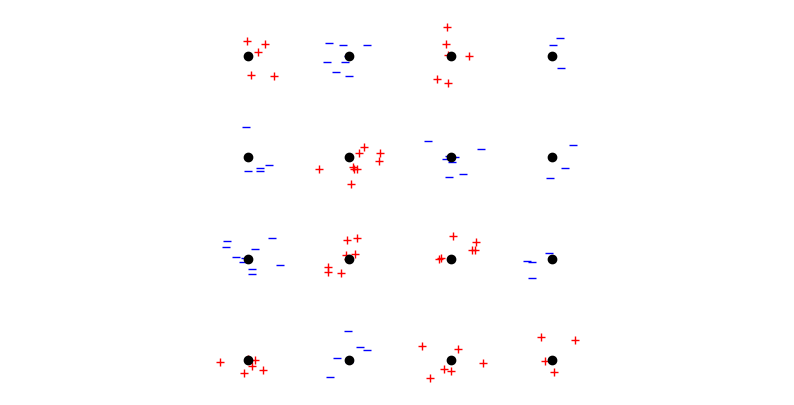

In [119]:
PyPlot.clf()
p1 = plot_data(X, Y, k; save_flag=true, name="data_dist_1")
gcf()

## Plot single layer margins 


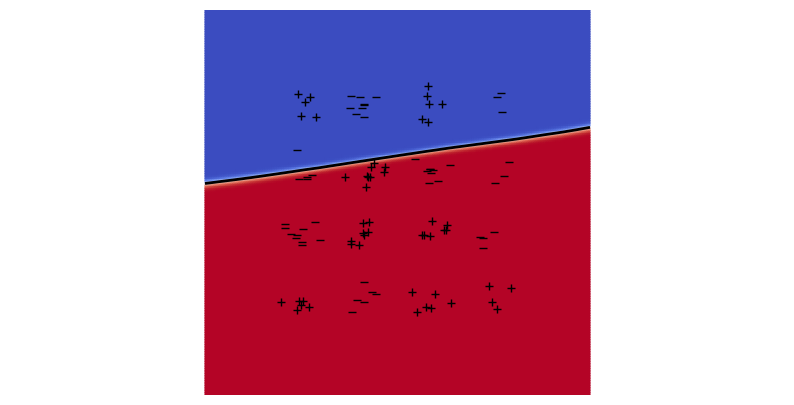

In [120]:
PyPlot.clf()
p2 = plot_margins(X, Y, Ws_single; save_flag=true, name="single")
gcf()

## Plot double layer margins

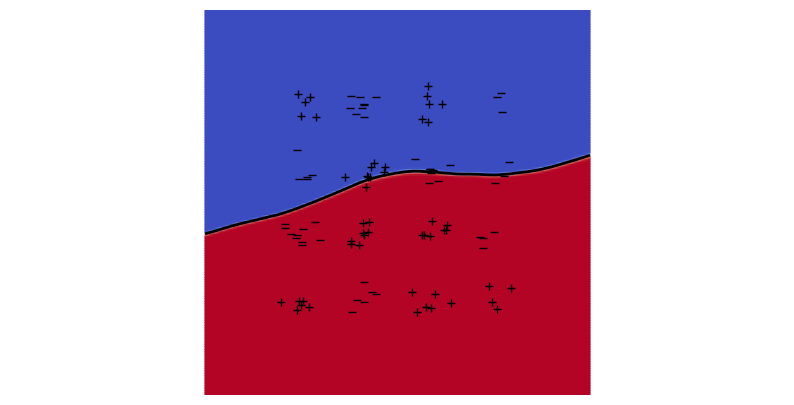

In [121]:
PyPlot.clf()
p3 = plot_margins(X, Y, Ws_both; save_flag=false, name="both")
gcf()

## Plot all together

In [8]:
function plot_dist_and_margins(k, n, m, t, save_name; save_flag=save, activation_function=relu_act)
    X, Y, Ws_single, loss_single, margins_single, betas_single = train_network(k, n, m, t; stepsize=0.5, both=false, activation_function=activation_function)
    Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=true, activation_function=activation_function)

    PyPlot.clf()
    fig = figure("data dist and margins",figsize=(7.5,2.5))
    # fig = figure("data dist and margins")

    subplot(131)
    p1 = plot_data(X, Y, k; save_flag=false, name="data_dist_1")
    # axis("equal");axis("off")
    PyPlot.title("data dist")

    subplot(132)
    p2 = plot_margins(X, Y, Ws_single; save_flag=false, name="single")
    # axis("equal");axis("off")
    PyPlot.title("Margins Single")

    subplot(133)
    p3 = plot_margins(X, Y, Ws_both; save_flag=false, name="both")
    # axis("equal");axis("off")
    PyPlot.title("Margins Double")
    PyPlot.suptitle("", y=1.12)
    if save_flag
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
    return fig
end
    

plot_dist_and_margins (generic function with 1 method)

In [9]:
function plot_dist_and_margins_given_X_Y(X, Y, k, n, m, t, save_name; save_flag=save, activation_function=relu_act)
    Ws_single, loss_single, margins_single, betas_single = train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=false, activation_function=activation_function)
    Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=true, activation_function=activation_function)

    PyPlot.clf()
    fig = figure("data dist and margins",figsize=(7.5,2.5))
    # fig = figure("data dist and margins")

    subplot(131)
    p1 = plot_data(X, Y, k; save_flag=false, name="data_dist_1")
    # axis("equal");axis("off")
    PyPlot.title("data dist")

    subplot(132)
    p2 = plot_margins(X, Y, Ws_single; save_flag=false, name="single")
    # axis("equal");axis("off")
    PyPlot.title("Margins Single")

    subplot(133)
    p3 = plot_margins(X, Y, Ws_both; save_flag=false, name="both")
    # axis("equal");axis("off")
    PyPlot.title("Margins Double")
    # PyPlot.suptitle("", y=1.12)
    if save_flag
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
    return fig
end
    

plot_dist_and_margins_given_X_Y (generic function with 1 method)

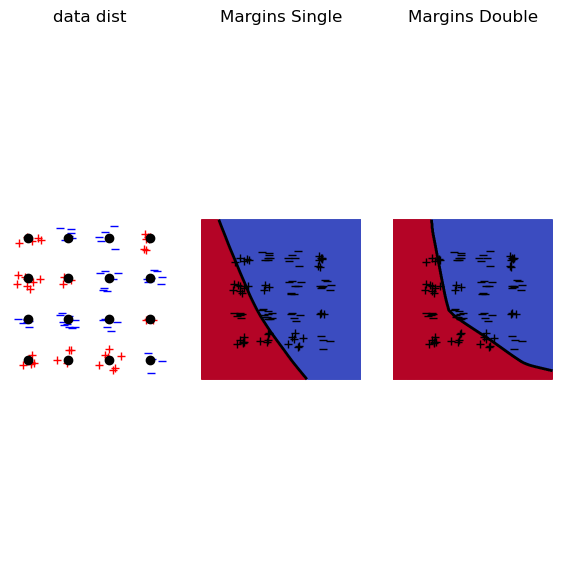

In [122]:
plot_dist_and_margins(4, 100, 500, 1000, "data and margin"; save_flag=false)
gcf()

### Recreate Figure 1 - Multiple Experiments of Plotting Data and Margins

In [10]:
function plot_data_margins_multiple_dists(k, n, m, niter, repeats; save_flag=false, save_name="dist_and_margins", activation_function=relu_act)
    PyPlot.clf()
    fig = figure("data dist and margins")
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for i in 1:repeats
        X, Y = get_X_Y(k, n)
        Ws_single, loss_single, margins_single, betas_single = train_network_given_X_Y(X, Y, m, niter; stepsize=0.5, both=false, activation_function=activation_function)
        Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, Y, m, niter; stepsize=0.5, both=true, activation_function=activation_function)

        subplot(repeats, 3, (3*i)-2)
        p1 = plot_data(X, Y, k; save_flag=false, name="data_dist_1")
        # axis("equal");axis("off")
        PyPlot.title("Data Dist")

        subplot(repeats, 3, (3*i)-1)
        p2 = plot_margins(X, Y, Ws_single; save_flag=false, name="single")
        # axis("equal");axis("off")
        PyPlot.title("Margins Single")

        subplot(repeats, 3, (3*i))
        p3 = plot_margins(X, Y, Ws_both; save_flag=false, name="single")
        # axis("equal");axis("off")
        PyPlot.title("Margins Both")
    end

    if save_flag
        savefig("diagrams/" * save_name * ".pdf", bbox_inches="tight")
    end
end

plot_data_margins_multiple_dists (generic function with 1 method)

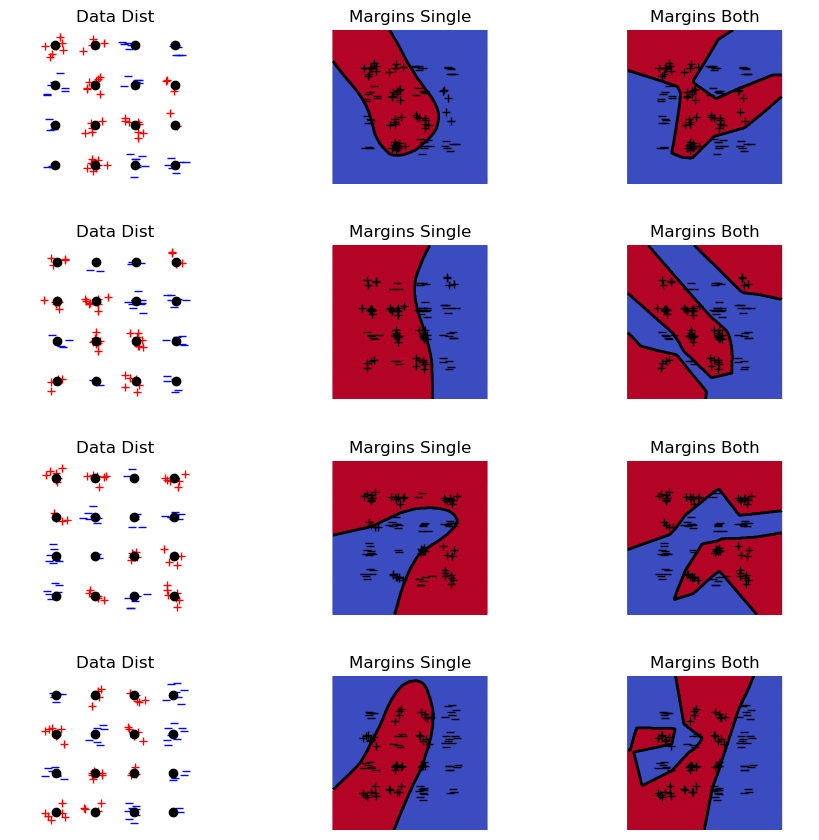

In [125]:
k = 4
n = 100
m = 500
niter = 50000
repeats = 4
save = true

plot_data_margins_multiple_dists(k, n, m, niter, repeats; save_flag=save, save_name="dist_and_margins_repeats", activation_function=relu_act)
gcf()

## Testing the Network

In [11]:
function train_and_test_model(X_train, Y_train, X_test, Y_test, n_train, m, k, d, n_test, niter, stepsize, both_flag; activation_function=relu_act)
    # train network
    Ws, loss, margins, betas = twonet(X_train[1:n_train, :], Y_train[1:n_train, :], m, stepsize, niter; both=both_flag, activation_function=activation_function)
    # predict test set 
    preds = (1/m) * sum(Ws[:,end,end] .* max.( Ws[:,1:end-1,end] * X_test', 0.0), dims = 1) 
    # probability of error 
    loss = sum((Y_test .* preds') .< 0)/n_test # probability of error
    GC.gc()
    max_margin = maximum(margins)
    return loss, max_margin
end

train_and_test_model (generic function with 1 method)

In [12]:
function train_and_test_model_return_weights_trainloss_testloss(X_train, Y_train, X_test, Y_test, n_train, m, k, d, n_test, niter, stepsize, both_flag; activation_function=relu_act)
    # train network
    Ws, loss, margins, betas = twonet(X_train[1:n_train, :], Y_train[1:n_train, :], m, stepsize, niter; both=both_flag, activation_function=activation_function)
    # predict test set 
    preds = (1/m) * sum(Ws[:,end,end] .* max.( Ws[:,1:end-1,end] * X_test', 0.0), dims = 1) 
    # probability of error 
    test_loss = sum((Y_test .* preds') .< 0)/n_test # probability of error
    train_loss = calculate_loss(Ws, niter, m, X_train, Y_train, n_train)
    GC.gc()
    max_margin = maximum(margins)
    return test_loss, max_margin, Ws, train_loss
end

train_and_test_model_return_weights_trainloss_testloss (generic function with 1 method)

In [13]:
function calculate_loss(Ws, niter, m, X, Y, n_samples)
    preds = (1/m) * sum(Ws[:,end,niter] .* max.( Ws[:,1:end-1,niter] * X', 0.0), dims = 1) 
    loss = sum((Y .* preds') .< 0)/n_samples # probability of error

end

calculate_loss (generic function with 1 method)

### Experiment 1 - Performance As n Increases

In [14]:
function experiment_ns(d, k, m, niter, stepsize, n_trains, n_test; both_layers=[true, false], repeats=1, activation_function=relu_act, save_flag=false)
    loss_single = zeros(repeats, 1, length(n_trains), 1) # (repeats, no of ds, no of ns, no of ms)
    loss_both = zeros(repeats, 1, length(n_trains), 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_single = zeros(repeats, 1, length(n_trains), 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_both = zeros(repeats, 1, length(n_trains), 1) # (repeats, no of ds, no of ns, no of ms)
    loss_arrays = [loss_both, loss_single]
    max_margins_arrays = [max_margin_both, max_margin_single]
    X_test, Y_test = get_X_Y(k, n_test; d=d)

    p = Progress(length(loss_both))
    for repeat in 1:repeats
        X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, maximum(n_trains), n_test; d=d)
        
        for i in 1:length(n_trains)
            n_train = n_trains[i]
            for (both, loss_array, max_margin_array) in zip(both_layers, loss_arrays, max_margins_arrays)
                loss, max_margin = train_and_test_model(X_train, Y_train, 
                                    X_test, Y_test, 
                                    n_train, m, k, d, 
                                    n_test, niter, 
                                    stepsize, both; activation_function=activation_function)
    
                loss_array[repeat,1,i,1] = loss
                max_margin_array[repeat,1,i,1] = max_margin  
            end
        end
        next!(p)
    end

    writedlm("experiment_ns_loss_single.csv", loss_single, ',')
    writedlm("experiment_ns_loss_both.csv", loss_both, ',')
    writedlm("experiment_ns_max_margin_single.csv", max_margin_single, ',')
    writedlm("experiment_ns_max_margin_both.csv", max_margin_both, ',')

    PyPlot.clf()
    tight_layout()
    fig = PyPlot.figure("experiment_ns", figsize=(10,5))

    subplot(121)
    plot_data(X_test, Y_test, k; save_flag=false)
    PyPlot.title("Test Data Distribution")

    subplot(122)
    plot(n_trains, loss_single[:, 1, :, 1]', "C0--",alpha=0.2)
    plot(n_trains, loss_both[:, 1, :, 1]', "C1--",alpha=0.2)
    plot(n_trains, mean(loss_single[:,1,:,1], dims=1)[:], "C0", linewidth=4,label="single ouput layer")
    plot(n_trains, mean(loss_both[:,1,:,1], dims=1)[:], "C1", linewidth=4,label="both layers")
    # axis("tight")
    PyPlot.title("Performance as number of training samples (n) increases")
    PyPlot.xlabel(L"n", fontsize=10)
    PyPlot.ylabel("Test Error", fontsize=10)
    PyPlot.legend();

    PyPlot.suptitle("", y=1.12)
    if save_flag
        save_name = "diagrams/experiment_ns" * "_" * string(n_trains) * "_niterdkmss" * string(niter) * string(d) * string(k) * string(m) * string(stepsize)
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
end

experiment_ns (generic function with 1 method)

In [57]:
d = 15
k = 4
m = 1000
niter = 50000
stepsize = 1.0
n_trains = [32,64,128,256,512]
n_test = 4000
repeats = 10
save_flag = true

experiment_ns(d, k, m, niter, stepsize, n_trains, n_test; repeats=repeats, save_flag=save_flag)
gcf()

### Experiment 2 - Performance As d Increases

In [15]:
function experiment_ds(ds, k, m, niter, stepsize, n_train, n_test; both_layers=[true, false], repeats=1, activation_function=relu_act, save_flag=false)
    loss_single = zeros(repeats, length(ds), 1, 1) # (repeats, no of ds, no of ns, no of ms)
    loss_both = zeros(repeats, length(ds), 1, 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_single = zeros(repeats, length(ds), 1, 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_both = zeros(repeats, length(ds), 1, 1) # (repeats, no of ds, no of ns, no of ms)
    loss_arrays = [loss_both, loss_single]
    max_margins_arrays = [max_margin_both, max_margin_single]
    X_test, Y_test = get_X_Y(k, n_test)
    p = Progress(length(repeats))
    for repeat in 1:repeats
        for i in 1:length(ds)
            d = ds[i]
            X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)
            for (both, loss_array, max_margin_array) in zip(both_layers, loss_arrays, max_margins_arrays)
                loss, max_margin = train_and_test_model(X_train, Y_train, 
                                    X_test, Y_test, 
                                    n_train, m, k, d, 
                                    n_test, niter, 
                                    stepsize, both; activation_function=activation_function)
    
                loss_array[repeat,i,1,1] = loss
                max_margin_array[repeat,i,1,1] = max_margin
            end
        end
        next!(p)
    end

    writedlm("experiment_ds_loss_single.csv", loss_single, ',')
    writedlm("experiment_ds_loss_both.csv", loss_both, ',')
    writedlm("experiment_ds_max_margin_single.csv", max_margin_single, ',')
    writedlm("experiment_ds_max_margin_both.csv", max_margin_both, ',')

    PyPlot.clf()
    tight_layout()
    fig = PyPlot.figure("experiment_ds", figsize=(10,5))

    subplot(121)
    plot_data(X_test, Y_test, k; save_flag=false)
    PyPlot.title("Test Data Distribution")

    subplot(122)
    plot(ds, loss_single[:, :, 1, 1]', "C0--",alpha=0.2)
    plot(ds, loss_both[:, :, 1, 1]', "C1--",alpha=0.2)
    plot(ds, mean(loss_single[:, :, 1, 1], dims=1)[:], "C0", linewidth=4,label="single ouput layer")
    plot(ds, mean(loss_both[:, :, 1, 1], dims=1)[:], "C1", linewidth=4,label="both layers")
    PyPlot.title("Performance as d increases")
    PyPlot.xlabel(L"d", fontsize=15)
    PyPlot.ylabel("Test Error", fontsize=15)
    PyPlot.legend()

    PyPlot.suptitle("", y=1.12)
    if save_flag
        save_name = "diagrams/experiment_ds" * "_" * string(ds) * "_niterkmss" * string(niter) * string(k) * string(m) * string(stepsize)
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
    
end

experiment_ds (generic function with 1 method)

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\Kevalee Shah\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


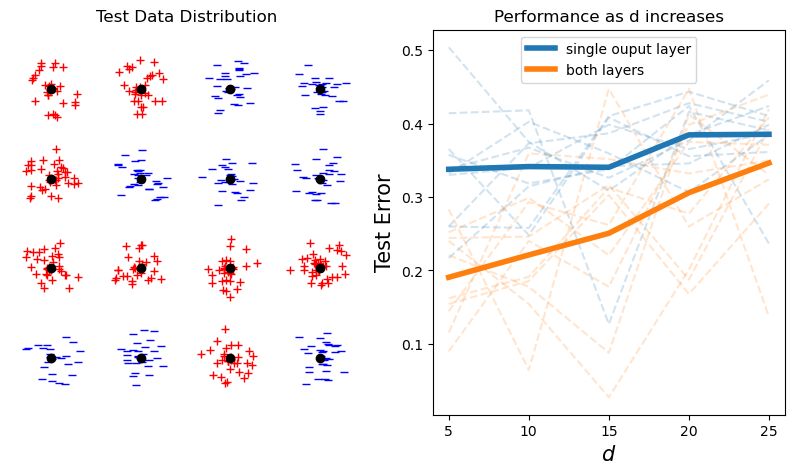

In [21]:
ds = [5, 10, 15, 20, 25]
k = 4
m = 1000
niter = 10000
stepsize = 0.5
n_train = 256
n_test = 512
repeats = 10
save_flag = true

experiment_ds(ds, k, m, niter, stepsize, n_train, n_test; repeats=repeats, save_flag=save_flag)
gcf()

### Experiment 3 - Performance As m Increases

In [16]:
function experiment_ms(d, k, ms, niter, stepsize, n_train, n_test; repeats=1, activation_function=relu_act, save_flag=false)
    
    loss_both = zeros(repeats, 1, 1, length(ms)) # (repeats, no of ds, no of ns, no of ms)
    max_margin_both = zeros(repeats, 1, 1, length(ms)) # (repeats, no of ds, no of ns, no of ms)
    X_test, Y_test = get_X_Y(k, n_test; d=d)
    
    for repeat in 1:repeats
        X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)
        p = Progress(length(ms))
        for i in 1:length(ms)
            m = ms[i]
            both = true
            loss, max_margin = train_and_test_model(X_train, Y_train, 
                                X_test, Y_test, 
                                n_train, m, k, d, 
                                n_test, niter, 
                                stepsize, both; activation_function=activation_function)

            loss_both[repeat,1,1,i] = loss
            max_margin_both[repeat,1,1,i] = max_margin
            next!(p)
        end
        
    end

    writedlm("experiment_ms_loss_both.csv", loss_both, ',')
    writedlm("experiment_ms_max_margin_both.csv", max_margin_both, ',')

    PyPlot.clf()
    PyPlot.tight_layout()
    fig = PyPlot.figure("experiment_ms", figsize=(10,5))

    subplot(121)
    plot_data(X_test, Y_test, k; save_flag=false)
    PyPlot.title("Test Data Distribution")

    subplot(122)
    semilogx(ms,max_margin_both[:,1,1,:]', "+r", alpha=0.5);
    semilogx(ms,sum(max_margin_both[:,1,1,:],dims=1)[:]/repeats,linewidth=3, "k");

    PyPlot.title("F1 Margin vs m with Both Layers Training")
    PyPlot.xlabel(L"m", fontsize=10)
    PyPlot.ylabel(L"$\mathcal{F}_1$ margin", fontsize=10)

    PyPlot.suptitle("", y=1.12)
    if save_flag
        save_name = "diagrams/experiment_ms" * "_" * string(ms) * "_niterdkss" * string(niter) * string(d) * string(k) * string(stepsize)
        savefig(save_name * ".pdf", bbox_inches="tight")
    end

end

experiment_ms (generic function with 1 method)

Progress:  25%|███████████                              |  ETA: 0:00:43

Progress:  38%|████████████████                         |  ETA: 0:00:28

Progress:  50%|█████████████████████                    |  ETA: 0:00:22

Progress:  62%|██████████████████████████               |  ETA: 0:00:19

Progress:  75%|███████████████████████████████          |  ETA: 0:00:17

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:35


Progress:  25%|███████████                              |  ETA: 0:00:37

Progress:  38%|████████████████                         |  ETA: 0:00:24

Progress:  50%|█████████████████████                    |  ETA: 0:00:18

Progress:  62%|██████████████████████████               |  ETA: 0:00:17

Progress:  75%|███████████████████████████████          |  ETA: 0:00:15

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


Progress:  25%|███████████                              |  ETA: 0:00:39

Progress:  38%|████████████████                         |  ETA: 0:00:25

Progress:  50%|█████████████████████                    |  ETA: 0:00:19

Progress:  62%|██████████████████████████               |  ETA: 0:00:18

Progress:  75%|███████████████████████████████          |  ETA: 0:00:16

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


Progress:  25%|███████████                              |  ETA: 0:00:37

Progress:  38%|████████████████                         |  ETA: 0:00:24

Progress:  50%|█████████████████████                    |  ETA: 0:00:18

Progress:  62%|██████████████████████████               |  ETA: 0:00:17

Progress:  75%|███████████████████████████████          |  ETA: 0:00:15

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:31


Progress:  25%|███████████                              |  ETA: 0:00:37

Progress:  38%|████████████████                         |  ETA: 0:00:24

Progress:  50%|█████████████████████                    |  ETA: 0:00:18

Progress:  62%|██████████████████████████               |  ETA: 0:00:17

Progress:  75%|███████████████████████████████          |  ETA: 0:00:15

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


Progress:  25%|███████████                              |  ETA: 0:00:37

Progress:  38%|████████████████                         |  ETA: 0:00:24

Progress:  50%|█████████████████████                    |  ETA: 0:00:18

Progress:  62%|██████████████████████████               |  ETA: 0:00:17

Progress:  75%|███████████████████████████████          |  ETA: 0:00:15

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:33


Progress:  25%|███████████                              |  ETA: 0:00:37

Progress:  38%|████████████████                         |  ETA: 0:00:24

Progress:  50%|█████████████████████                    |  ETA: 0:00:18

Progress:  62%|██████████████████████████               |  ETA: 0:00:17

Progress:  75%|███████████████████████████████          |  ETA: 0:00:15

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:34


Progress:  25%|███████████                              |  ETA: 0:00:37

Progress:  38%|████████████████                         |  ETA: 0:00:24

Progress:  50%|█████████████████████                    |  ETA: 0:00:18

Progress:  62%|██████████████████████████               |  ETA: 0:00:20

Progress:  75%|███████████████████████████████          |  ETA: 0:00:17

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:39


Progress:  25%|███████████                              |  ETA: 0:00:36

Progress:  38%|████████████████                         |  ETA: 0:00:24

Progress:  50%|█████████████████████                    |  ETA: 0:00:18

Progress:  62%|██████████████████████████               |  ETA: 0:00:17

Progress:  75%|███████████████████████████████          |  ETA: 0:00:15

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:33


Progress:  25%|███████████                              |  ETA: 0:00:38

Progress:  38%|████████████████                         |  ETA: 0:00:25

Progress:  50%|█████████████████████                    |  ETA: 0:00:19

Progress:  62%|██████████████████████████               |  ETA: 0:00:18

Progress:  75%|███████████████████████████████          |  ETA: 0:00:16

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:02:37


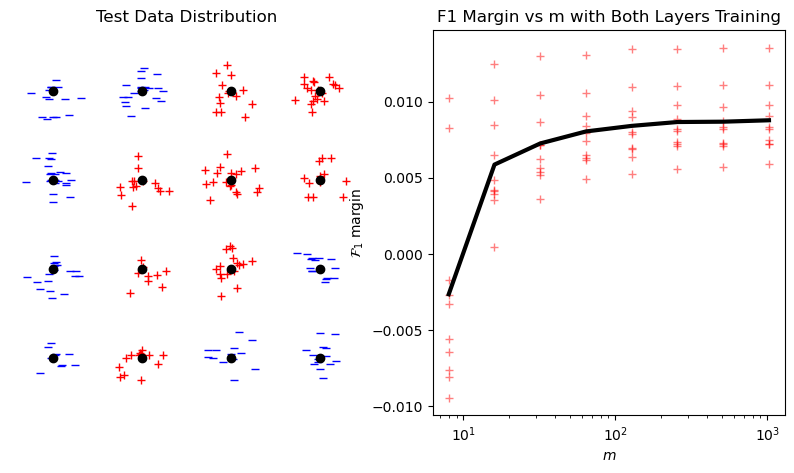

In [56]:
d = 15
k = 4
ms = [8,16,32,64,128,256,512,1024]
niter = 15000
stepsize = 1.0
n_train = 256
n_test = 256
repeats = 10
save_flag = true

experiment_ms(d, k, ms, niter, stepsize, n_train, n_test; repeats=repeats, save_flag=save_flag)
gcf()

### Experiment 4 - Change in Margins as niter increases

Dynamics of the classifier while training both layers for an initialization with a large
variance and a small initial step-size. The classifier first approaches the max-margin
classifier for the tangent kernel (Jacot et al., 2018) (c) and eventually converges to the
F1-max-margin (f).

In Figure 3, we illustrate for d = 2 a case where two
different kinds of implicit biases show up in a single dynamics (t is the number of iterations with a constant step-size). We initialize the ReLU network with a large variance (N(0; 402)).

In [12]:
function experiment_niters(d, k, m, niters, stepsize, n_train; both_layers=[true, false])
    X_train, Y_train = get_X_Y(k, n_train; d=d)
    weights_single = zeros(m, d+1, maximum(niters), length(niters)) # (m, d+1, the maximum number of iterations, how many niters that are being tried)
    weights_both = zeros(m, d+1, maximum(niters), length(niters)) # (m, d+1, the maximum number of iterations, how many niters that are being tried)
    weights_layers = [weights_single, weights_both]
    for i in 1:length(niters)
        for (both, weights_layer) in zip(both_layers, weights_layers)
            niter = niters[i]
            Ws, loss, margins, betas = train_network_given_X_Y(X_train, Y_train, m, niter; stepsize=stepsize, both=both)
            weights_layer[:, :, 1:niter, i] = Ws
        end
    end

    return X_train, Y_train, weights_single, weights_both
end

experiment_niters (generic function with 1 method)

In [ ]:
d = 43
k = 4
m = 1000
niters = [5, 10, 15, 20, 25]
n_train = 500
stepsize = 0.5

X_train, Y_train, weights_single, weights_both = experiment_niters(d, k, m, niters, stepsize, n_train; both_layers=[true, false])

In [14]:
function simple_plot_niters(d, k, m, niters, n_train, stepsize; save_flag=false, save_name=("experiment_niters_"*string(niters)), both_layers=[true, false])
    GC.gc()
    X_train, Y_train = get_X_Y(k, n_train; d=d)
    PyPlot.clf()
    plot_data(X_train, Y_train, k; save_flag=true)
    max_niter = maximum(niters)
    
    Ws_single, loss_single, margins_single, betas_single = train_network_given_X_Y(X_train, Y_train, m, max_niter; stepsize=stepsize, both=false)
    Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X_train, Y_train, m, max_niter; stepsize=stepsize, both=true)

    # single
    PyPlot.clf()
    tight_layout()
    fig = PyPlot.figure("experiment_niters_single", figsize=(20,5)) 
    for i in 1:length(niters)
        subplot_number = 100 + (10*length(niters)) + i
        subplot(subplot_number)
        niter = niters[i]
        p1 = plot_margins(X_train, Y_train, Ws_single[:, :, 1:niter])
        PyPlot.title("niter = " * string(niter))
        GC.gc()
    end
    if save_flag
        savefig(save_name * "_single.pdf", bbox_inches="tight")
    end

    # both
    PyPlot.clf()
    tight_layout()
    fig = PyPlot.figure("experiment_niters_both", figsize=(20,5)) 
    for i in 1:length(niters)
        subplot_number = 100 + (10*length(niters)) + i
        subplot(subplot_number)
        niter = niters[i]
        p1 = plot_margins(X_train, Y_train, Ws_both[:, :, 1:niter])
        PyPlot.title("niter = " * string(niter))
    end
    if save_flag
        savefig(save_name * "_both.pdf", bbox_inches="tight")
    end
end

simple_plot_niters (generic function with 1 method)

In [236]:
d = 15
k = 4
m = 1000
niters = [100, 500, 1000, 5000, 10000, 50000, 100000]
# niters = [1,2,3,4]
n_train = 256
stepsize = 0.5
save_flag = true 
for random_number in [20, 35, 7, 2, 101]
    Random.seed!(random_number)
    save_name = "diagrams/experiment_niters_repeat4_" * string(niters) * "d_" * string(d) * "rand_" * string(random_number)
    simple_plot_niters(d, k, m, niters, n_train, stepsize; save_flag=save_flag, save_name=save_name)
    GC.gc()
end

## Extension

### Experiment 0 - Training Error as niter increases

In [17]:
function plot_training_loss_single_both(d, k, m, niter, stepsize, n_train; both_layers=[true, false], activation_function=relu_act, save_flag=false, save_name="plot training error")
    X_train, Y_train = get_X_Y(k, n_train; d=d)
    loss_single = zeros(size(2:100:niter))
    loss_both = zeros(size(2:100:niter))
    loss_layers = [loss_both, loss_single]
    for (both_flag, loss_layer) in zip(both_layers, loss_layers)
        Ws, loss, margins, betas = twonet(X_train, Y_train, m, stepsize, niter; both=both_flag, activation_function=activation_function)
        for i in 1:length(2:100:niter)
            t = (2:100:niter)[i]
            loss_layer[i] = calculate_loss(Ws, t, m, X_train, Y_train, n_train)
        end
    end
    GC.gc()

    PyPlot.clf()
    # tight_layout()
    fig = PyPlot.figure("experiment_training_error", figsize=(10,5))

    subplot(131)
    p1 = plot_data(X_train, Y_train, k; save_flag=false, name="")
    # axis("tight")
    PyPlot.title("Data Dist")

    subplot(132)
    plot((2:100:niter), loss_single, "C0", linewidth=2, label="single layer training loss")
    axis("tight")
    PyPlot.title("Training Loss of Single Layer")
    PyPlot.xlabel(L"niter", fontsize=10)
    PyPlot.ylabel("Error", fontsize=10)
    PyPlot.legend(loc="upper center");

    subplot(133)
    plot((2:100:niter), loss_both, "C1", linewidth=2, label="both layer training loss")
    axis("tight")
    PyPlot.title("Training Loss of Both Layers")
    PyPlot.xlabel(L"niter", fontsize=10)
    PyPlot.ylabel("Error", fontsize=10)
    PyPlot.legend(loc="upper center");

    PyPlot.suptitle("", y=1.12)
    if save_flag
        savefig("diagrams/" * save_name * ".pdf", bbox_inches="tight")
    end
end

function plot_training_loss_both(d, k, m, niter, stepsize, n_train; activation_function=relu_act, save_flag=false, save_name="plot training error both")
    X_train, Y_train = get_X_Y(k, n_train; d=d)
    loss_both = zeros(size(2:100:niter))
    Ws, loss, margins, betas = twonet(X_train, Y_train, m, stepsize, niter; both=true, activation_function=activation_function)
    for i in 1:length(2:100:niter)
        t = (2:100:niter)[i]
        loss_both[i] = calculate_loss(Ws, t, m, X_train, Y_train, n_train)
    end
    GC.gc()
    
    PyPlot.clf()
    # tight_layout()
    fig = PyPlot.figure("experiment_training_error", figsize=(10,5))

    subplot(121)
    p1 = plot_data(X_train, Y_train, k; save_flag=false, name="")
    # axis("tight")
    PyPlot.title("Data Dist")

    subplot(122)
    plot((2:100:niter), loss_both, "C1", linewidth=2, label="both layer training loss")
    axis("tight")
    PyPlot.title("Training Loss of Both Layers")
    PyPlot.xlabel(L"niter", fontsize=10)
    PyPlot.ylabel("Error", fontsize=10)
    PyPlot.legend(loc="upper center");

    PyPlot.suptitle("", y=1.12)

    
    if save_flag
        savefig("diagrams/" * save_name * ".pdf", bbox_inches="tight")
    end
end


plot_training_loss_both (generic function with 1 method)

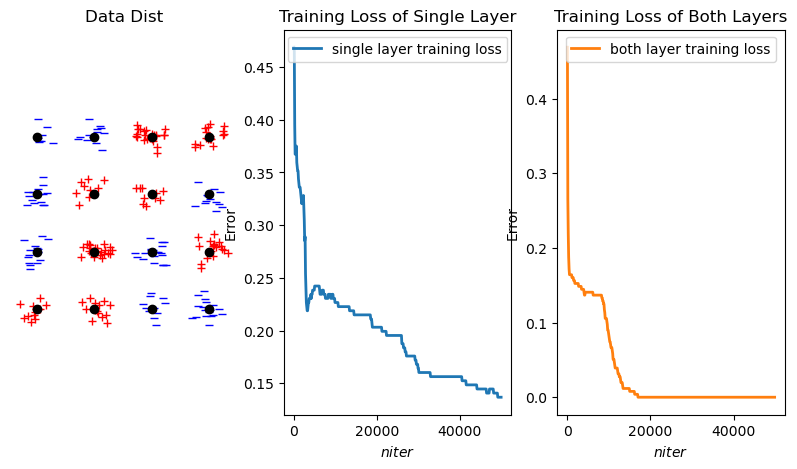

In [42]:
d = 3
k = 4
m = 500
niter = 50000
stepsize = 1
n_train = 256
save_flag = true
save_name = "training_error_plot_single_both_dkmniterssntrain" * string(d) * string(k) * string(m) * string(niter) * string(stepsize) * string(n_train) 
plot_training_loss_single_both(d, k, m, niter, stepsize, n_train; activation_function=relu_act, save_flag=save_flag, save_name=save_name)
gcf()

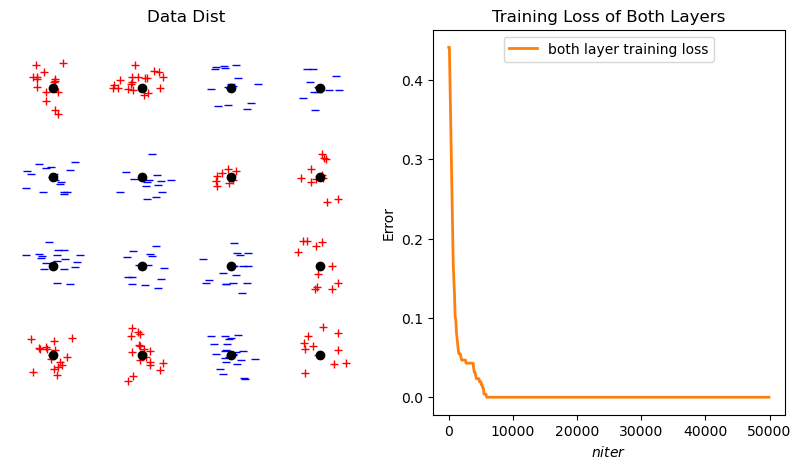

In [43]:
d = 3
k = 4
m = 500
niter = 50000
stepsize = 1
n_train = 256
save_flag = true
save_name = "training_error_plot_both_dkmniterssntrain" * string(d) * string(k) * string(m) * string(niter) * string(stepsize) * string(n_train)
plot_training_loss_both(d, k, m, niter, stepsize, n_train; activation_function=relu_act, save_flag=save_flag, save_name=save_name)
gcf()

### Experiment Activations

#### ReLU

In [18]:
function relu_act(x)
    return max(x, 0)
end

relu_act (generic function with 1 method)

#### ELU

In [19]:
function elu_act(x; a=0.1)
    if x<0
        return a*(exp(x)-1)
    else
        return x
    end
end

elu_act (generic function with 1 method)

#### Leaky ReLU

In [20]:
function leaky_relu_act(x)
    if x<0
        return 0.01*x
    else
        return x
    end
end

leaky_relu_act (generic function with 1 method)

#### Sigmoid

In [21]:
function sigmoid_act(x)
    return 1/(1+exp(-x))
end

sigmoid_act (generic function with 1 method)

#### Tanh

In [22]:
function tanh_act(x)
    return (2 * sigmoid_act(2*x)) - 1
end

tanh_act (generic function with 1 method)

#### Swish

In [23]:
function swish_act(x)
    return x*sigmoid_act(x)
end

swish_act (generic function with 1 method)

In [50]:
activation_functions = [relu_act, elu_act, leaky_relu_act, sigmoid_act, tanh_act, swish_act]
activation_function_names = ["relu", "elu", "leaky_relu", "sigmoid", "tanh", "swish"]
k = 4
n = 200
m = 500
t = 50000
save = true
X, Y = get_X_Y(k,n)

for (act_function, act_name) in zip(activation_functions, activation_function_names)
    name = "diagrams/dist_and_margings_" * string(k) * "_" * string(n) * "_" * string(m) * "_" * string(t) * "_" * act_name
    plot_dist_and_margins_given_X_Y(X, Y, k, n, m, t, name; save_flag=save, activation_function=act_function)
    GC.gc()
end

### Experiment 5 - Training Loss and Activations

In [24]:
function plot_training_test_loss_activations(d, k, m, niter, stepsize, n_train, n_test, acts, act_names; both_layers=[true, false], save_flag=false)
    X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)

    PyPlot.clf()
    # tight_layout()
    fig = PyPlot.figure("activations_and_errors", figsize=(7,7))
    fig.set_figheight(10)
    fig.set_figwidth(7)

    for i in 1:length(both_layers)
        both_flag = both_layers[i]
        
        if both_flag
            both_name = "Both"
        else
            both_name = "Single"
        end

        sampling = 2:100:niter
    

        loss_train = zeros(length(sampling), length(acts))
        loss_test = zeros(length(sampling), length(acts))
        

        for j in 1:length(acts)
            act = acts[j]
            Ws, loss, margins, betas = twonet(X_train, Y_train, m, stepsize, niter; both=both_flag, activation_function=act)
            for i in 1:length(sampling)
                t = sampling[i]
                loss_train_value = calculate_loss(Ws, t, m, X_train, Y_train, n_train)
                loss_test_value = calculate_loss(Ws, t, m, X_test, Y_test, n_test)
                loss_train[i, j] = loss_train_value
                loss_test[i, j] = loss_test_value
            end
        end

        colours = ["b", "g", "r", "c", "m", "y"]

        subplot(2, 1, i)
        for j in 1:length(acts)
            colour = colours[j]
            colour_test = colour * "--"
            plot(sampling, loss_train[:, j], linewidth=2, label=(act_names[j]*" train"), colour)
            plot(sampling, loss_test[:, j], linewidth=2, label=(act_names[j]*" test"), colour_test)   
        end
        
        axis("tight")
        PyPlot.title("Training and Test Loss " * both_name)
        PyPlot.xlabel(L"niter", fontsize=10)
        PyPlot.ylabel("Error", fontsize=10)
        PyPlot.legend(loc="upper right")
    end

    
    PyPlot.suptitle("", y=1.12)
    if save_flag
        save_name = "activations_vs_error" * "_dkmssniter" * string(d) * string(k) * string(m) * string(stepsize) * string(niter)
        # savefig("testing_saving.pdf", bbox_inches="tight")
        println(save_name)
        savefig(("diagrams/" * save_name * ".pdf"), bbox_inches="tight")
    end
end

plot_training_test_loss_activations (generic function with 1 method)

activations_vs_error_dkmniter4450050000


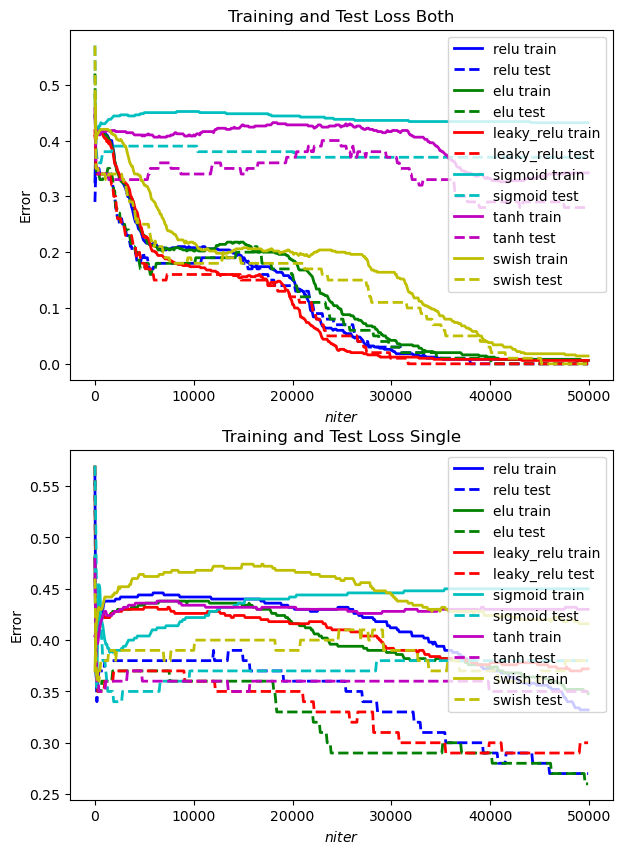

In [110]:
d = 4
k = 4
m = 500
niter = 50000
stepsize = 0.5
n_train = 500
n_test = 100
acts = [relu_act, elu_act, leaky_relu_act, sigmoid_act, tanh_act, swish_act]
act_names = ["relu", "elu", "leaky_relu", "sigmoid", "tanh", "swish"]
save_flag = true
plot_training_test_loss_activations(d, k, m, niter, stepsize, n_train, n_test, acts, act_names; save_flag=save_flag)
gcf()

### Experiment 6 - Training Loss vs Testing Loss

Plot test loss for fixed everything as niter increases

In [25]:
function plot_test_loss(k, m, d, n_train, n_test, niter, stepsize, both; save_flag=false)
    X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)
    if both
        both_name = "Both"
    else
        both_name = "Single"
    end

    loss_train = zeros(length(2:100:niter))
    loss_test = zeros(length(2:100:niter))

    # train the network for niter and record loss 
    Ws, loss, margins, betas = twonet(X_train, Y_train, m, stepsize, niter; both=both)
    
    # calculate loss at 100 itervals of niter
    for i in 1:length(2:100:niter)
        t = (2:100:niter)[i]
        loss_train_value = calculate_loss(Ws, t, m, X_train, Y_train, n_train)
        loss_test_value = calculate_loss(Ws, t, m, X_test, Y_test, n_test)
        loss_train[i] = loss_train_value
        loss_test[i] = loss_test_value
    end
    
    # plot
    PyPlot.clf()
    fig = PyPlot.figure("train and test loss")
    fig = figure("data dist and margins")
    fig.set_figheight(7)
    fig.set_figwidth(7)
    subplot(1, 2, 1)
    p1 = plot_data(X_test, Y_test, k; save_flag=false, name="data_dist_1")
    PyPlot.title("Data Dist")

    subplot(1, 2, 2)
    plot((2:100:niter), loss_train, linewidth=2, label="train loss")
    plot((2:100:niter), loss_test, linewidth=2, label="test loss")
    axis("tight")
    PyPlot.title("Training and Test Loss " * both_name)
    PyPlot.xlabel(L"niter", fontsize=10)
    PyPlot.ylabel("Error", fontsize=10)
    PyPlot.legend(loc="upper center")

    if save_flag
        save_name = "train_test_loss" * "_kmdntrainntestniterssboth" * string(k) * string(m) * string(d) * string(n_train) * string(n_test) * string(niter) * string(stepsize) * string(both) 
        # savefig("testing_saving.pdf", bbox_inches="tight")
        println(save_name)
        savefig(("diagrams/" * save_name * ".pdf"), bbox_inches="tight")
    end
    
end

plot_test_loss (generic function with 1 method)

train_test_loss_kmdntrainntestniterssboth3100015512400030001true


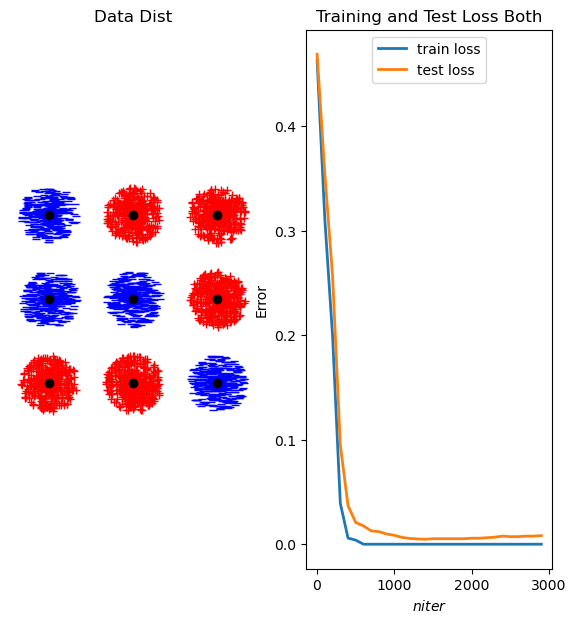

In [68]:
k = 3
m = 1000
d = 15
n_train = 512
n_test = 4000
niter = 3000
stepsize = 1
both = true
save_flag = true


plot_test_loss(k, m, d, n_train, n_test, niter, stepsize, both; save_flag=save_flag)
gcf()

In [ ]:
k = 3
m = 1000
d = 15
n_train = 512
n_test = 4000
niter = 100000
stepsize = 1
both = false
save_flag = true


plot_test_loss(k, m, d, n_train, n_test, niter, stepsize, both; save_flag=save_flag)
gcf()

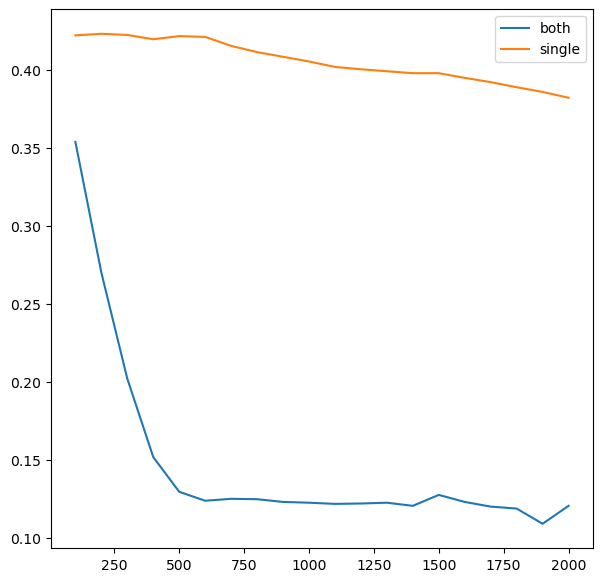

In [66]:
k = 3
d = 15
n_train = 100
n_test = 4000
m = 500
niter = 2000
stepsize = 1

# train neural network
X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)
# X_train, Y_train = get_X_Y(k, n_train; d=d)
# X_test, Y_test = get_X_Y(k, n_test; d=d)

Ws1, loss1, margins1, betas1 = twonet(X_train, Y_train, m, stepsize, niter; both=true)
Ws2, loss2, margins2, betas2 = twonet(X_train, Y_train, m, stepsize, niter; both=false)

loss_both = zeros(length(100:100:niter))
loss_single = zeros(length(100:100:niter))

for i in 1:length(2:100:niter)
    l_b = calculate_loss(Ws1, (100:100:niter)[i], m, X_test, Y_test, n_test)
    loss_both[i] = l_b
    l_s = calculate_loss(Ws2, (100:100:niter)[i], m, X_test, Y_test, n_test)
    loss_single[i] = l_s
end

PyPlot.clf()
plot((100:100:niter), loss_both, label="both")
plot((100:100:niter), loss_single, label="single")
legend() 
gcf()

In [57]:
for i in length(2:100:niter)
    print(i)
end

10

### Experiment 7 - Does Double Descent Happen?

In [26]:
function train_and_test_loss_vs_m(d, k, max_m, increment, niter, n_train, n_test; repeats=1, stepsize=0.5, both=true, save_flag=true, activation_function=relu_act)
    interval = 2:increment:max_m
    train_loss = zeros(repeats, length(interval))
    test_loss = zeros(repeats, length(interval))

    p = Progress(length(repeats))
    for repeat in 1:repeats
        for i in 1:length(interval)
            m = interval[i]
            X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)

            # train the network for niter and record loss 
            Ws, loss, margins, betas = twonet(X_train, Y_train, m, stepsize, niter; both=both, activation_function=activation_function)
            loss_train_value = calculate_loss(Ws, niter, m, X_train, Y_train, n_train)
            loss_test_value = calculate_loss(Ws, niter, m, X_test, Y_test, n_test)
            train_loss[repeat, i] = loss_train_value
            test_loss[repeat, i] = loss_test_value
        end
        next!(p)
    end

    writedlm("experiment_doubledesc_train_loss.csv", train_loss, ',')
    writedlm("experiment_doubledesc_test_loss.csv", test_loss, ',')

    PyPlot.clf()
    PyPlot.tight_layout()
    fig = PyPlot.figure("experiment_double_desc", figsize=(10,5))

    subplot(1,1,1)
    plot(interval, train_loss[:,:]', "C0--", alpha=0.2)
    plot(interval, test_loss[:,:]', "C1--", alpha=0.2)
    plot(interval, mean(train_loss[:, :], dims=1)[:], "C0", linewidth=3, label="train loss")
    plot(interval, mean(test_loss[:, :], dims=1)[:], "C1", linewidth=3, label="test loss")
    PyPlot.title("Train and Test Loss as the number of neurons increases")
    PyPlot.xlabel(L"m", fontsize=10)
    PyPlot.ylabel("Error", fontsize=10)
    PyPlot.legend()


    PyPlot.suptitle("", y=1.12)
    if save_flag
        save_name = "diagrams/experiment_doubledesc" * "_niterdkmaxmintervalssntrainntest" * string(niter) * string(d) * string(k) * string(max_m) * string(increment) * string(stepsize) * string(n_train) * string(n_test)
        println(save_name)
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
end

train_and_test_loss_vs_m (generic function with 1 method)

diagrams/experiment_doubledesc_niterdkmaxmintervalssntrainntest150004441001001.0256256


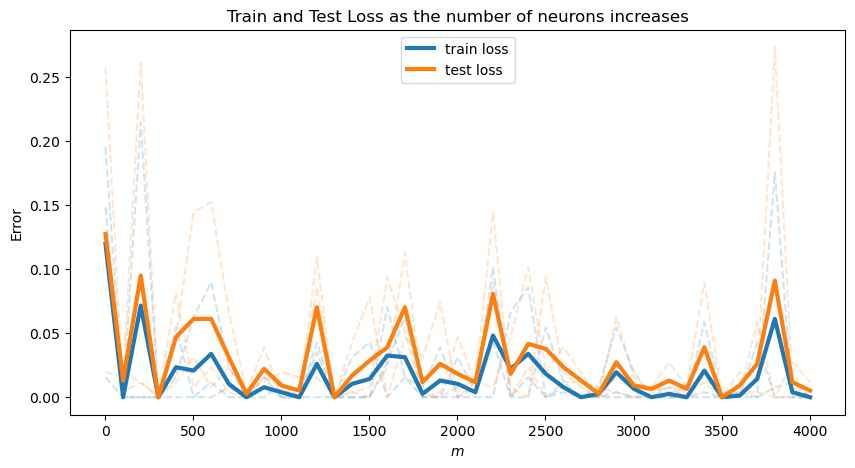

In [27]:
d = 4
k = 4
max_m = 4100
increment = 100
niter = 15000
n_train = 256
n_test = 256
repeats = 3
stepsize = 1.0
both = true
save_flag = true

train_and_test_loss_vs_m(d, k, max_m, increment, niter, n_train, n_test; 
                            repeats=repeats, stepsize=stepsize, both=both, save_flag=save_flag)
gcf()

### Experiment 8 Plot train and test margins

In [27]:
function plot_train_test_margins_for_activations(d, k, m, n_train, n_test, niter; 
    stepsize=0.5, both_flag=true, acts=[relu_act, elu_act, leaky_relu_act, sigmoid_act, tanh_act, swish_act], 
    act_names = ["relu", "elu", "leaky_relu", "sigmoid", "tanh", "swish"], save_flag=false)

    X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)
    if both_flag
        both_name = "Both Layers"
    else
        both_name = "Single Layer"
    end

    PyPlot.clf()
    fig = PyPlot.figure("train test margins for activations")
    fig.set_figheight(20)
    fig.set_figwidth(8)

    p = Progress(length(acts))
    for i in 1:length(acts)
        act = acts[i]
        act_name = act_names[i]
        Ws, loss, margins, betas = twonet(X_train, Y_train, m, stepsize, niter; both=both_flag, activation_function=act)
        loss_train_value = round(calculate_loss(Ws, niter, m, X_train, Y_train, n_train); digits=4)
        loss_test_value = round(calculate_loss(Ws, niter, m, X_test, Y_test, n_test); digits=4)
        
        # # plot train margin
        # subplot(length(acts), 2, (2*i)-1)
        # plot_margins(X_train, Y_train, Ws; save_flag=false)
        # train_title = both_name * " Training Margins - Loss = " * string(loss_train_value)
        # PyPlot.title(train_title,fontsize=10)
        
        # # plot test margin
        # subplot(length(acts), 2, 2*i)
        # plot_margins(X_test, Y_test, Ws; save_flag=false)
        # test_title = both_name * " Testing Margins - Loss = " * string(loss_test_value)
        # PyPlot.title(test_title, fontsize=10)

        # plot train margin
        subplot(length(acts), 3, (3*i)-2)
        plot_margins(X_train, Y_train, Ws; save_flag=false)
        train_title = both_name * " Training Margins - Loss = " * string(loss_train_value)
        PyPlot.title(train_title,fontsize=10)
        
        subplot(length(acts), 3, (3*i)-1)
        plot()
        PyPlot.title(act_name)
        axis("off")
        
        # plot test margin
        subplot(length(acts), 3, 3*i)
        plot_margins(X_test, Y_test, Ws; save_flag=false)
        test_title = both_name * " Testing Margins - Loss = " * string(loss_test_value)
        PyPlot.title(test_title, fontsize=10)
        next!(p)
    end

    if save_flag
        save_name = "activations_vs_margins" * "_dkmssniterntrainntest" * string(d) * string(k) * string(m) * string(stepsize) * string(niter) * string(n_train) * string(n_test)
        savefig(("diagrams/" * save_name * ".pdf"), bbox_inches="tight")
    end
end

plot_train_test_margins_for_activations (generic function with 1 method)

Progress:  33%|██████████████                           |  ETA: 0:12:31

Progress:  50%|█████████████████████                    |  ETA: 0:08:49

Progress:  67%|████████████████████████████             |  ETA: 0:06:11

Progress:  83%|███████████████████████████████████      |  ETA: 0:03:12

Progress: 100%|█████████████████████████████████████████| Time: 0:19:40


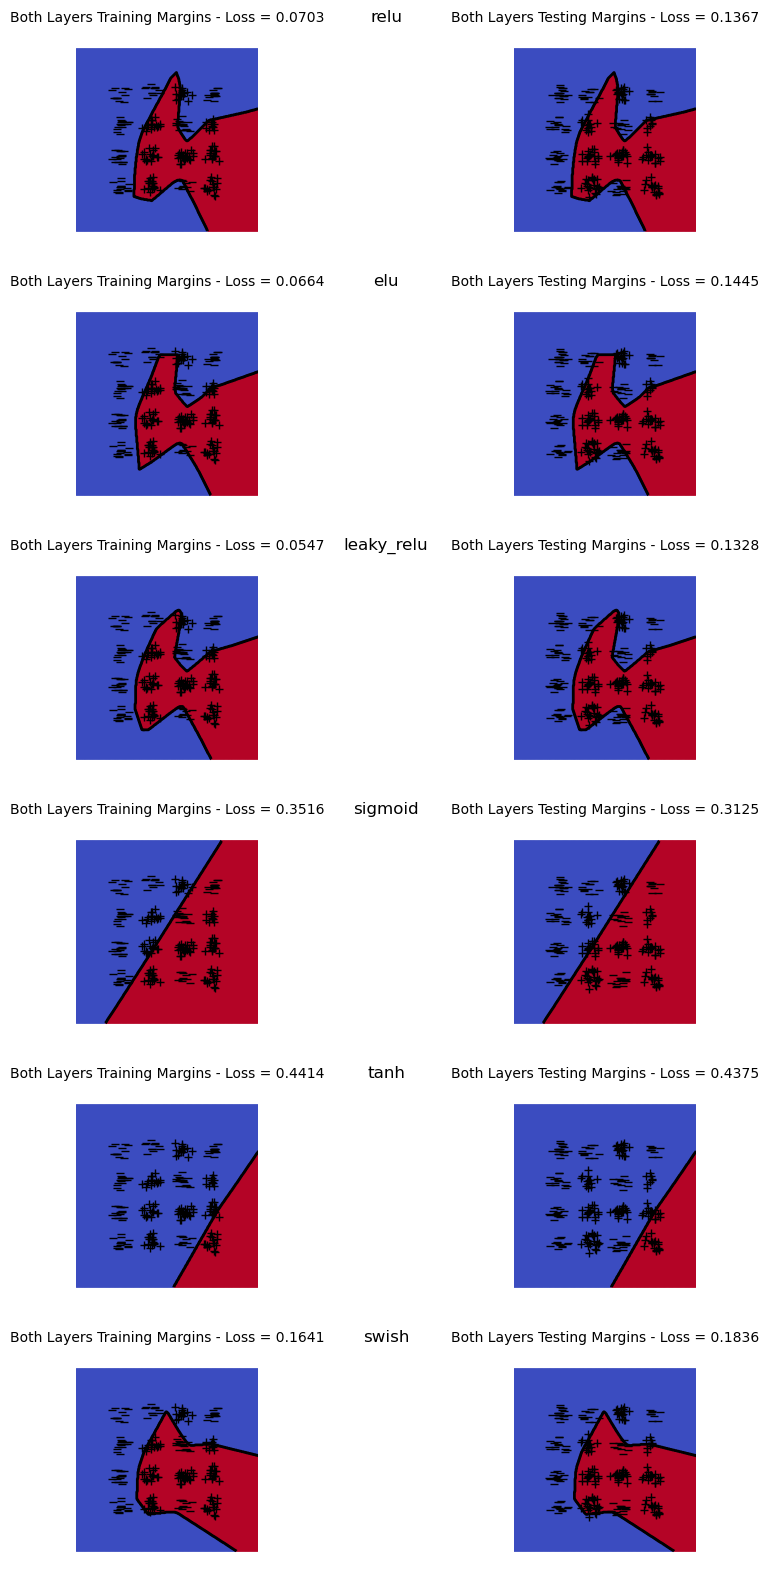

In [49]:
d = 4
k = 4
m = 500
niter = 50000
n_train = 256
n_test = 256
both = true
save_flag = true

plot_train_test_margins_for_activations(d, k, m, n_train, n_test, niter; save_flag=save_flag, both_flag=both)
gcf()

### Experiment 9 - Performance as k increases

In [37]:
function experiment_ks(d, ks, m, niter, stepsize, n_train, n_test; both_layers=[true, false], repeats=1, activation_function=relu_act, save_flag=false)
    loss_single = zeros(repeats, 1, length(ks), 1) # (repeats, no of ds, no of ks, no of ms)
    loss_both = zeros(repeats, 1, length(ks), 1) # (repeats, no of ds, no of ks, no of ms)
    max_margin_single = zeros(repeats, 1, length(ks), 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_both = zeros(repeats, 1, length(ks), 1) # (repeats, no of ds, no of ns, no of ms)
    loss_arrays = [loss_both, loss_single]
    max_margins_arrays = [max_margin_both, max_margin_single]
    X_test, Y_test = get_X_Y(ks[1], n_test; d=d)
    both_names = ["Both", "Single"]


    p = Progress(repeats)
    for repeat in 1:repeats
        PyPlot.clf()
        tight_layout()
        fig = PyPlot.figure("experiment_ks_margins")
        fig.set_figheight(15)
        fig.set_figwidth(15)

        for i in 1:length(ks)
            k = ks[i]
            X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)
            for (j, (both, both_name, loss_array, max_margin_array)) in enumerate(zip(both_layers, both_names, loss_arrays, max_margins_arrays))
                test_loss, max_margin, Ws, train_loss = train_and_test_model_return_weights_trainloss_testloss(X_train, Y_train, 
                                    X_test, Y_test, 
                                    n_train, m, k, d, 
                                    n_test, niter, 
                                    stepsize, both; activation_function=activation_function)
    
                loss_array[repeat,1,i,1] = test_loss
                max_margin_array[repeat,1,i,1] = max_margin  

                # plot margins
                figure_number_train = i + (((2*j)-2)*length(ks))
                figure_number_test = i + (((2*j)-1)*length(ks))
                subplot(4, length(ks), figure_number_train)
                plot_margins(X_train, Y_train, Ws; save_flag=false)
                if j==1
                    title_name = "k = " * string(k) * "\n" * both_name * " Training Margins \n Loss = " * string(train_loss)
                else
                    title_name =  both_name * " Training Margins \n Loss = " * string(train_loss)
                end
                PyPlot.title(title_name, fontsize=10)

                subplot(4, length(ks), figure_number_test)
                plot_margins(X_test, Y_test, Ws; save_flag)
                title_name = both_name * " Testing Margins \n Loss = " * string(test_loss)
                PyPlot.title(title_name, fontsize=10)
            end
        end
        if save_flag
            save_name = "diagrams/experiment_ks_margins_" * string(ks) * "_niterdmss" * string(niter) * string(d) * string(m) * string(stepsize) * "repeat_" * string(repeat)
            savefig(save_name * ".pdf", bbox_inches="tight")
        end
        next!(p)
    end

    writedlm("experiment_ks_loss_single.csv", loss_single, ',')
    writedlm("experiment_ks_loss_both.csv", loss_both, ',')
    writedlm("experiment_ks_max_margin_single.csv", max_margin_single, ',')
    writedlm("experiment_ks_max_margin_both.csv", max_margin_both, ',')

    PyPlot.clf()
    tight_layout()
    fig = PyPlot.figure("experiment_ks", figsize=(10,5))

    # subplot(121)
    # plot_data(X_test, Y_test, k; save_flag=false)
    # PyPlot.title("Test Data Distribution for k=" * string(ks[length(ks)]))

    subplot(111)
    plot(ks, loss_single[:, 1, :, 1]', "C0--",alpha=0.2)
    plot(ks, loss_both[:, 1, :, 1]', "C1--",alpha=0.2)
    plot(ks, mean(loss_single[:,1,:,1], dims=1)[:], "C0", linewidth=4,label="single ouput layer")
    plot(ks, mean(loss_both[:,1,:,1], dims=1)[:], "C1", linewidth=4,label="both layers")
    # axis("tight")
    PyPlot.title("Performance as k increases")
    PyPlot.xlabel(L"k", fontsize=10)
    PyPlot.ylabel("Test Error", fontsize=10)
    PyPlot.legend();

    PyPlot.suptitle("", y=1.12)
    if save_flag
        save_name = "diagrams/experiment_ks" * "_" * string(ks) * "_niterdmss" * string(niter) * string(d) * string(m) * string(stepsize)
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
end

sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.


experiment_ks (generic function with 1 method)

Progress:  67%|████████████████████████████             |  ETA: 0:06:28

Progress: 100%|█████████████████████████████████████████| Time: 0:22:09


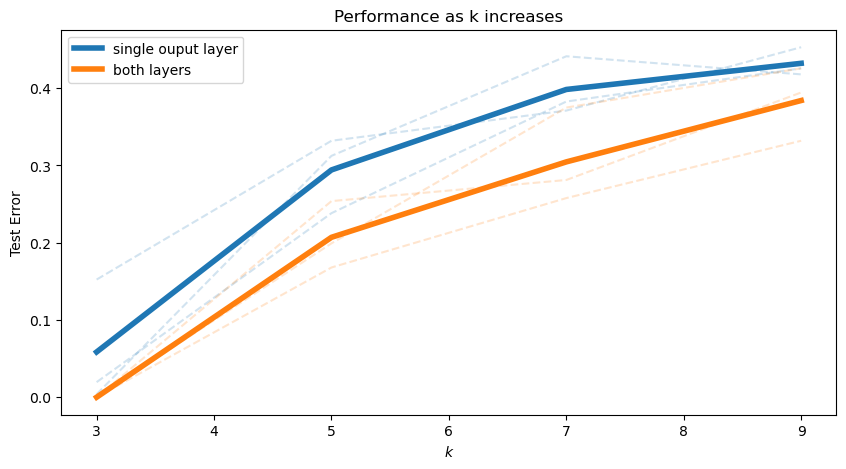

In [42]:
d = 4
ks = [3, 5, 7, 9]
m = 500
niter = 15000
stepsize = 1.0
n_train = 256
n_test = 256
repeats=3
save_flag = true

experiment_ks(d, ks, m, niter, stepsize, n_train, n_test; repeats=repeats, save_flag=save_flag)
gcf()

### Experiment 10 - Performance as step size increases

In [ ]:
function experiment_ss(d, k, m, niter, stepsizes, n_train, n_test; both_layers=[true, false], repeats=1, activation_function=relu_act, save_flag=false)
    loss_single = zeros(repeats, 1, length(stepsizes), 1) # (repeats, no of ds, no of ks, no of ms)
    loss_both = zeros(repeats, 1, length(stepsizes), 1) # (repeats, no of ds, no of ks, no of ms)
    max_margin_single = zeros(repeats, 1, length(stepsizes), 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_both = zeros(repeats, 1, length(stepsizes), 1) # (repeats, no of ds, no of ns, no of ms)
    loss_arrays = [loss_both, loss_single]
    max_margins_arrays = [max_margin_both, max_margin_single]
    X_test, Y_test = get_X_Y(k, n_test; d=d)
    both_names = ["Both", "Single"]


    p = Progress(repeats)
    for repeat in 1:repeats
        X_train, Y_train, X_test, Y_test = get_X_Y_train_test(k, n_train, n_test; d=d)
        
        PyPlot.clf()
        tight_layout()
        fig = PyPlot.figure("experiment_ss_margins")
        fig.set_figheight(15)
        fig.set_figwidth(15)

        for i in 1:length(stepsizes)
            ss = stepsizes[i]
            
            for (j, (both, both_name, loss_array, max_margin_array)) in enumerate(zip(both_layers, both_names, loss_arrays, max_margins_arrays))
                test_loss, max_margin, Ws, train_loss = train_and_test_model_return_weights_trainloss_testloss(X_train, Y_train, 
                                    X_test, Y_test, 
                                    n_train, m, k, d, 
                                    n_test, niter, 
                                    ss, both; activation_function=activation_function)
    
                loss_array[repeat,1,i,1] = test_loss
                max_margin_array[repeat,1,i,1] = max_margin  

                # plot margins
                figure_number_train = i + (((2*j)-2)*length(stepsizes))
                figure_number_test = i + (((2*j)-1)*length(stepsizes))
                subplot(4, length(stepsizes), figure_number_train)
                plot_margins(X_train, Y_train, Ws; save_flag=false)
                if j==1
                    title_name = "ss = " * string(ss) * "\n" * both_name * " Training Margins \n Loss = " * string(train_loss)
                else
                    title_name =  both_name * " Training Margins \n Loss = " * string(train_loss)
                end
                PyPlot.title(title_name, fontsize=10)

                subplot(4, length(stepsizes), figure_number_test)
                plot_margins(X_test, Y_test, Ws; save_flag)
                title_name = both_name * " Testing Margins \n Loss = " * string(test_loss)
                PyPlot.title(title_name, fontsize=10)
            end
        end
        if save_flag
            save_name = "diagrams/experiment_ss_margins_" * string(stepsizes) * "_niterdkm" * string(niter) * string(d) * string(k) * string(m) * "repeat_" * string(repeat)
            savefig(save_name * ".pdf", bbox_inches="tight")
        end
        next!(p)
    end

    writedlm("experiment_ks_loss_single.csv", loss_single, ',')
    writedlm("experiment_ks_loss_both.csv", loss_both, ',')
    writedlm("experiment_ks_max_margin_single.csv", max_margin_single, ',')
    writedlm("experiment_ks_max_margin_both.csv", max_margin_both, ',')

    PyPlot.clf()
    tight_layout()
    fig = PyPlot.figure("experiment_ks", figsize=(10,5))

    # subplot(121)
    # plot_data(X_test, Y_test, k; save_flag=false)
    # PyPlot.title("Test Data Distribution for k=" * string(ks[length(ks)]))

    subplot(111)
    plot(ks, loss_single[:, 1, :, 1]', "C0--",alpha=0.2)
    plot(ks, loss_both[:, 1, :, 1]', "C1--",alpha=0.2)
    plot(ks, mean(loss_single[:,1,:,1], dims=1)[:], "C0", linewidth=4,label="single ouput layer")
    plot(ks, mean(loss_both[:,1,:,1], dims=1)[:], "C1", linewidth=4,label="both layers")
    # axis("tight")
    PyPlot.title("Performance as k increases")
    PyPlot.xlabel(L"k", fontsize=10)
    PyPlot.ylabel("Test Error", fontsize=10)
    PyPlot.legend();

    PyPlot.suptitle("", y=1.12)
    if save_flag
        save_name = "diagrams/experiment_ks" * "_" * string(ks) * "_niterdkmss" * string(niter) * string(d) * string(k) * string(m) * string(stepsize)
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
end